## This code downloads monthly data on Arbeitsstellen and Arbeitssuchende from the BA, extracts relevant tables and merges them into a data frame

Source: https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?r_f=bl_Baden-Wuerttemberg&topic_f=berufe-heft-kldb2010

The difference of this data and the earlier scraped data on Arbeitsstellen is that this data set also includes Arbeitssuchend, which is a more suitable variable when constructing a labor market tighntess index (Abraham et. Al. 2022)

Prepare environment: 

In [28]:
# Install Packages that are required for this procedure

# Settings

import pandas as pd

pd.set_option('display.max.rows', None)
pd.set_option('display.max.columns', None)


!pip install xlrd selenium pandas openpyxl requests os


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement os (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for os


Next, I automatically download all relevant excel files from the BA's website:

In [29]:

#######

# 1. Step: Automized download of all excel files (February 2020 - February 2025) from the BA website (https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?topic_f=analyse-gemeldete-arbeitsstellen-kldb2010)


#######

# === Load Packages ===

from selenium import webdriver # Selenium is used for the automatic download of files from the web browser
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import os
import requests
import urllib.parse
import time

# === Setup Edge ===

# The microsoft edge driver is required for selenium to work. This code opens the microsoft edge driver:
service = Service("C:\\Users\\jhummels\\OneDrive - DIW Berlin\\Gehlen, Annica's files - retirement-labor-shortages\\edgedriver\\msedgedriver.exe")
options = webdriver.EdgeOptions()
options.add_argument("start-maximized")
driver = webdriver.Edge(service=service, options=options)

# === Opening Ergebnisseite ===

# This command opens the BA's website from which we want to download all the excel sheets 
driver.get("https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?r_f=bl_Baden-Wuerttemberg&topic_f=berufe-heft-kldb2010")
wait = WebDriverWait(driver, 20)

# === Accepting Cookie-Banner ===

# If we don't deal with the cookies window that automatically opens when opening the website link, our webscraping will not work. The following code adresses 
# this problem. However, the command still has issues with accepting cookies by itself, so when the cookie window opens you have to manually accept cookies and then the code will run errorless. Except for 
# accepting cookies, you shoule not do anything in the window while the code is running. Once the command is executed, the window should close automatically. 
try:
    cookie_button = wait.until(EC.element_to_be_clickable((By.ID, "cc-all")))
    cookie_button.click()
    print("✅ Cookies akzeptiert.")
    time.sleep(2)
except:
    print("ℹ️ Kein Cookie-Banner gefunden oder schon geschlossen.") # This is the response you will get if you accept cookies manually, which you have to do. 

# === Navigation through all subpages and collection of all Excel-Links ===

# The following code browses through all subpages on the website and obtains all links, which initiate the download of excel files

all_excel_links = []
page_number = 1

while True:
    print(f"\n🔄 Lade Seite {page_number}...")

    try:
        wait.until(EC.presence_of_all_elements_located((By.XPATH, "//a[contains(@href, '.xls')] | //a[contains(@href, '.xlsx')]")))
    except:
        print("❌ Keine Excel-Links gefunden auf dieser Seite.")
        break

    elements = driver.find_elements(By.XPATH, "//a[contains(@href, '.xls')] | //a[contains(@href, '.xlsx')]")
    for el in elements:
        href = el.get_attribute("href")
        if href and href not in all_excel_links:
            all_excel_links.append(href)

    # Searching for next subtab and press 'next'
    try:
        next_link = driver.find_element(By.XPATH, "//a[contains(@class, 'forward') and contains(@class, 'button')]")
        ActionChains(driver).move_to_element(next_link).perform()
        next_link.click()
        time.sleep(2)
        page_number += 1
    except:
        print("✅ Keine weitere Seite gefunden oder Button deaktiviert.")
        break

driver.quit()

# === Printing all Excel-Links ===
print(f"\n🔗 Insgesamt {len(all_excel_links)} Excel-Dateien gefunden.")

# === Preparing Download-Folder ===
os.makedirs(r"C:\Users\jhummels\OneDrive - DIW Berlin\Gehlen, Annica's files - retirement-labor-shortages\Data\Labor Market Tightness", exist_ok=True)
failed_links = []

# === Hilfsfunktion: Retry-Logik ===
def download_with_retries(url, retries=3, delay=5):
    headers = {"User-Agent": "Mozilla/5.0"}
    for i in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=20)
            if response.status_code == 200:
                return response
        except Exception as e:
            print(f"⚠️ Versuch {i+1} fehlgeschlagen für {url}: {e}")
            time.sleep(delay)
    return None

# === Download Excel-Files ===
for link in all_excel_links:
    filename = link.split("/")[-1].split("?")[0].split(";")[0]
    filename = urllib.parse.unquote(filename)
    filepath = os.path.join(r"C:\Users\jhummels\OneDrive - DIW Berlin\Gehlen, Annica's files - retirement-labor-shortages\Data\Labor Market Tightness", filename)

    # Falls Datei schon existiert, überspringen
    if os.path.exists(filepath):
        print(f"⏩ Überspringe bereits vorhandene Datei: {filename}")
        continue

    print(f"⬇️ Lade herunter: {filename}")
    response = download_with_retries(link)
    if response:
        try:
            with open(filepath, "wb") as f:
                f.write(response.content)
            print(f"✅ Erfolgreich gespeichert: {filename}")
        except Exception as e:
            print(f"❌ Fehler beim Speichern von {filename}: {e}")
            failed_links.append(link)
    else:
        print(f"❌ Endgültig fehlgeschlagen: {filename}")
        failed_links.append(link)

# === Safe all failed links ===
if failed_links:
    with open("failed_excels.txt", "w", encoding="utf-8") as f:
        for link in failed_links:
            f.write(link + "\n")
    print(f"\n⚠️ {len(failed_links)} Dateien konnten nicht geladen werden. Gespeichert in 'failed_excels.txt'")
else:
    print("\n🎉 Alle Excel-Dateien erfolgreich heruntergeladen!")


ℹ️ Kein Cookie-Banner gefunden oder schon geschlossen.

🔄 Lade Seite 1...

🔄 Lade Seite 2...

🔄 Lade Seite 3...

🔄 Lade Seite 4...

🔄 Lade Seite 5...

🔄 Lade Seite 6...

🔄 Lade Seite 7...

🔄 Lade Seite 8...

🔄 Lade Seite 9...
✅ Keine weitere Seite gefunden oder Button deaktiviert.

🔗 Insgesamt 166 Excel-Dateien gefunden.
⬇️ Lade herunter: berufe-heft-kldb2010-dwol-0-202504-xlsx.xlsx
✅ Erfolgreich gespeichert: berufe-heft-kldb2010-dwol-0-202504-xlsx.xlsx
⬇️ Lade herunter: berufe-heft-kldb2010-dwol-0-202503-xlsx.xlsx
✅ Erfolgreich gespeichert: berufe-heft-kldb2010-dwol-0-202503-xlsx.xlsx
⬇️ Lade herunter: berufe-heft-kldb2010-dwol-0-202502-xlsx.xlsx
✅ Erfolgreich gespeichert: berufe-heft-kldb2010-dwol-0-202502-xlsx.xlsx
⬇️ Lade herunter: berufe-heft-kldb2010-dwol-0-202501-xlsx.xlsx
✅ Erfolgreich gespeichert: berufe-heft-kldb2010-dwol-0-202501-xlsx.xlsx
⬇️ Lade herunter: berufe-heft-kldb2010-dwol-0-202412-xlsx.xlsx
✅ Erfolgreich gespeichert: berufe-heft-kldb2010-dwol-0-202412-xlsx.xlsx
⬇️

Next, I extract the tables from the sheets 4-20 from every excel file. Each sheet includes the desired table for each bundesland in this year and month. 

In [30]:
import os
import pandas as pd
import re
import xlrd 

# Path to the folder containing Excel files
excel_folder = r"C:\Users\jhummels\OneDrive - DIW Berlin\Gehlen, Annica's files - retirement-labor-shortages\Data\Labor Market Tightness"  # Change if needed

# Sheets to extract (1.4 through 1.19)
sheets_to_extract = [f"1.{i}" for i in range(4, 20)]

# List to store extracted data
all_dfs = []

# Loop over all Excel files
for file in os.listdir(excel_folder):
    if file.endswith(".xlsx") or file.endswith(".xls"):
        filepath = os.path.join(excel_folder, file)

        # Extract year and month from filename (e.g., 202005)
        match = re.search(r"(\d{6})", file)
        if not match:
            print(f"⚠️ No valid YYYYMM found in filename: {file}")
            continue

        year = int(match.group(1)[:4])
        month = int(match.group(1)[4:])

        try:
            xls = pd.ExcelFile(filepath)

            for sheet_name in sheets_to_extract:
                if sheet_name not in xls.sheet_names:
                    print(f"⚠️ Sheet '{sheet_name}' not found in {file}. Skipping.")
                    continue

                try:
                    df = pd.read_excel(xls, sheet_name=sheet_name, header=None)

                    # Add metadata
                    df["Year"] = year
                    df["Month"] = month
                    df["source_file"] = file
                    df["sheet_name"] = sheet_name

                    all_dfs.append(df)

                except Exception as e:
                    print(f"❌ Error reading sheet {sheet_name} in {file}: {e}")

        except Exception as e:
            print(f"❌ Error opening file {file}: {e}")

# Combine all DataFrames
if all_dfs:
    combined_excel_df = pd.concat(all_dfs, ignore_index=True)
    print(f"✓ Combined {len(all_dfs)} sheets. Total rows: {combined_excel_df.shape[0]}")
    print(combined_excel_df.head())
else:
    print("❗ No valid Excel sheets were processed.")


⚠️ No valid YYYYMM found in filename: berufe-heft-kldb2010-d-0-xls.xls
✓ Combined 2064 sheets. Total rows: 1322288
                                                   0    1    2    3    4    5  \
0                                                NaN  NaN  NaN  NaN  NaN  NaN   
1                                                NaN  NaN  NaN  NaN  NaN  NaN   
2  Arbeitsmarktdaten nach Zielberufen: Arbeitslos...  NaN  NaN  NaN  NaN  NaN   
3                                          Übersicht  NaN  NaN  NaN  NaN  NaN   
4  Ausgewiesenes Anforderungsniveau: Helfer, Fach...  NaN  NaN  NaN  NaN  NaN   

     6    7    8    9   10   11   12   13   14   15   16   17  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       

Output first rows of the extracted data frame: 

In [31]:
combined_excel_df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Year,Month,source_file,sheet_name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arbeitsmarktstatistik,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
2,Arbeitsmarktdaten nach Zielberufen: Arbeitslos...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
3,Übersicht,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
4,"Ausgewiesenes Anforderungsniveau: Helfer, Fach...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
5,Schleswig-Holstein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
6,2014-08-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
8,Berufe nach der Klassifikation der Berufe 2010...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4


In [32]:
combined_excel_df.dtypes

0              object
1              object
2              object
3              object
4              object
5              object
6              object
7              object
8              object
9              object
10             object
11             object
12             object
13             object
14             object
15             object
16             object
17             object
18             object
Year            int64
Month           int64
source_file    object
sheet_name     object
dtype: object

Cleaning the data and adjusting column names: 

In [33]:
import numpy as np

# 1. Rename columns properly 
combined_excel_df.columns = [
    "BKZ", "Beruf", "Anforderungsniveau", "Arbeitslose_Bestand", "Arbeitslose_Bestand_Vorjahr", "Arbeitslose_V_abs", "Arbeitslose_V_proz", "Arbeitssuchende_Bestand", "Arbeitssuchende_Bestand_Vorjahr", 
    "Arbeitssuchende_V_abs", "Arbeitssuchende_V_proz", "Arbeitsstellen_Bestand", "Arbeitsstellen_Bestand_Vorjahr", "Arbeitsstellen_V_abs", "Arbeitsstellen_V_proz", "Arbeitsstellen_Zugang", "Arbeitsstellen_Zugang_Vorjahr",
    "Arbeitsstellen_V_abs", "Arbeitsstellen_V_proz", "Year", "Month", "source_file", "Bundesland"
] 

# 2. Replace "x" and "*" with NaN
combined_excel_df.replace(["x", "*", "-"], np.nan, inplace=True)

# 3. Drop rows where Beruf is NaN or irrelevant
combined_excel_df = combined_excel_df[combined_excel_df["Beruf"].notna()]

# 4. Keep only rows that have a valid BKZ
combined_excel_df = combined_excel_df[combined_excel_df["BKZ"].notna()]


In [34]:
import numpy as np

combined_excel_df = combined_excel_df.replace(
    to_replace=r'^\s*[-x*]+\s*$', 
    value=np.nan, 
    regex=True
)
combined_excel_df.head(20)

C:\Users\jhummels\AppData\Local\Temp\ipykernel_15252\2298091171.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_excel_df = combined_excel_df.replace(


,BKZ,Beruf,Anforderungsniveau,Arbeitslose_Bestand,Arbeitslose_Bestand_Vorjahr,Arbeitslose_V_abs,Arbeitslose_V_proz,Arbeitssuchende_Bestand,Arbeitssuchende_Bestand_Vorjahr,Arbeitssuchende_V_abs,Arbeitssuchende_V_proz,Arbeitsstellen_Bestand,Arbeitsstellen_Bestand_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Arbeitsstellen_Zugang,Arbeitsstellen_Zugang_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Year,Month,source_file,Bundesland
21,11,"Land-, Tier-, Forstwirtschaftsberufe",Gesamt,1042.0,1071.0,-29.0,-2.7,1789.0,1782.0,7.0,0.4,110.0,77.0,33.0,42.9,632.0,579.0,53.0,9.2,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
25,111,Landwirtschaft,Gesamt,564.0,593.0,-29.0,-4.9,1026.0,1019.0,7.0,0.7,55.0,33.0,22.0,NaN,343.0,325.0,18.0,5.5,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
28,112,Tierwirtschaft,Gesamt,64.0,61.0,3.0,4.9,95.0,101.0,-6.0,-5.9,11.0,16.0,-5.0,NaN,73.0,67.0,6.0,9.0,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
30,113,Pferdewirtschaft,Gesamt,74.0,77.0,-3.0,-3.9,125.0,137.0,-12.0,-8.8,7.0,16.0,-9.0,NaN,78.0,101.0,-23.0,-22.8,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
32,114,Fischwirtschaft,Gesamt,49.0,47.0,2.0,NaN,74.0,68.0,6.0,8.8,3.0,4.0,-1.0,NaN,17.0,20.0,-3.0,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
33,115,Tierpflege,Gesamt,213.0,214.0,-1.0,-0.5,337.0,321.0,16.0,5.0,5.0,6.0,-1.0,NaN,53.0,52.0,1.0,1.9,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
35,12,"Gartenbauberufe, Floristik",Gesamt,3205.0,3238.0,-33.0,-1.0,5286.0,5395.0,-109.0,-2.0,303.0,273.0,30.0,11.0,1369.0,1230.0,139.0,11.3,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
39,121,Gartenbau,Gesamt,3068.0,3085.0,-17.0,-0.6,5029.0,5133.0,-104.0,-2.0,246.0,221.0,25.0,11.3,1159.0,1043.0,116.0,11.1,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
43,122,Floristik,Gesamt,137.0,153.0,-16.0,-10.5,257.0,262.0,-5.0,-1.9,57.0,52.0,5.0,9.6,210.0,187.0,23.0,12.3,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
45,21,"Rohstoffgewinn,Glas-,Keramikverarbeitung",Gesamt,55.0,40.0,15.0,NaN,98.0,81.0,17.0,21.0,23.0,20.0,3.0,NaN,105.0,39.0,66.0,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4


In [35]:
combined_excel_df.describe()    

,Arbeitslose_Bestand,Arbeitslose_Bestand_Vorjahr,Arbeitslose_V_abs,Arbeitslose_V_proz,Arbeitssuchende_Bestand,Arbeitssuchende_Bestand_Vorjahr,Arbeitssuchende_V_abs,Arbeitssuchende_V_proz,Arbeitsstellen_Bestand,Arbeitsstellen_Bestand_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Arbeitsstellen_Zugang,Arbeitsstellen_Zugang_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Year,Month
count,349001.000000,347812.000000,347695.000000,280746.000000,349196.000000,348818.000000,348798.000000,308620.000000,323174.000000,322056.000000,319909.000000,207291.000000,338734.000000,338636.000000,337248.000000,262749.000000,349255.000000,349255.000000
mean,1721.064968,1733.003718,-6.075051,0.882109,2924.012500,2955.980033,-28.807493,-0.191191,553.598009,540.599983,14.977172,6.420284,1492.546485,1524.411265,-31.595938,0.638853,2019.562254,6.497771
std,4794.287799,4810.782303,502.094087,16.395774,7839.894948,7887.066696,542.950877,13.719884,1178.494314,1154.227120,261.506802,28.295362,3331.086787,3373.226819,599.943910,25.283191,3.097240,3.484795
min,3.000000,3.000000,-12734.000000,-91.100000,3.000000,3.000000,-13334.000000,-94.700000,3.000000,3.000000,-5620.000000,-98.500000,3.000000,3.000000,-18109.000000,-98.200000,2014.000000,1.000000
25%,77.000000,78.000000,-36.000000,-9.200000,145.000000,147.000000,-54.000000,-8.000000,29.000000,29.000000,-14.000000,-11.200000,71.000000,71.000000,-55.000000,-14.100000,2017.000000,3.000000
50%,317.000000,320.000000,-2.000000,-1.600000,577.000000,582.000000,-4.000000,-1.700000,135.000000,131.000000,2.000000,3.600000,342.000000,348.000000,-2.000000,-1.600000,2020.000000,7.000000
75%,1350.000000,1362.000000,20.000000,8.600000,2361.000000,2391.750000,24.000000,5.600000,533.000000,521.000000,31.000000,19.700000,1380.000000,1422.000000,33.000000,11.100000,2022.000000,10.000000
max,92294.000000,92294.000000,18820.000000,247.600000,138301.000000,138301.000000,13305.000000,249.600000,18552.000000,18552.000000,5205.000000,249.800000,54875.000000,54875.000000,10642.000000,248.700000,2025.000000,12.000000


In [36]:
combined_excel_df.head(20)

,BKZ,Beruf,Anforderungsniveau,Arbeitslose_Bestand,Arbeitslose_Bestand_Vorjahr,Arbeitslose_V_abs,Arbeitslose_V_proz,Arbeitssuchende_Bestand,Arbeitssuchende_Bestand_Vorjahr,Arbeitssuchende_V_abs,Arbeitssuchende_V_proz,Arbeitsstellen_Bestand,Arbeitsstellen_Bestand_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Arbeitsstellen_Zugang,Arbeitsstellen_Zugang_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Year,Month,source_file,Bundesland
21,11,"Land-, Tier-, Forstwirtschaftsberufe",Gesamt,1042.0,1071.0,-29.0,-2.7,1789.0,1782.0,7.0,0.4,110.0,77.0,33.0,42.9,632.0,579.0,53.0,9.2,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
25,111,Landwirtschaft,Gesamt,564.0,593.0,-29.0,-4.9,1026.0,1019.0,7.0,0.7,55.0,33.0,22.0,NaN,343.0,325.0,18.0,5.5,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
28,112,Tierwirtschaft,Gesamt,64.0,61.0,3.0,4.9,95.0,101.0,-6.0,-5.9,11.0,16.0,-5.0,NaN,73.0,67.0,6.0,9.0,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
30,113,Pferdewirtschaft,Gesamt,74.0,77.0,-3.0,-3.9,125.0,137.0,-12.0,-8.8,7.0,16.0,-9.0,NaN,78.0,101.0,-23.0,-22.8,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
32,114,Fischwirtschaft,Gesamt,49.0,47.0,2.0,NaN,74.0,68.0,6.0,8.8,3.0,4.0,-1.0,NaN,17.0,20.0,-3.0,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
33,115,Tierpflege,Gesamt,213.0,214.0,-1.0,-0.5,337.0,321.0,16.0,5.0,5.0,6.0,-1.0,NaN,53.0,52.0,1.0,1.9,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
35,12,"Gartenbauberufe, Floristik",Gesamt,3205.0,3238.0,-33.0,-1.0,5286.0,5395.0,-109.0,-2.0,303.0,273.0,30.0,11.0,1369.0,1230.0,139.0,11.3,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
39,121,Gartenbau,Gesamt,3068.0,3085.0,-17.0,-0.6,5029.0,5133.0,-104.0,-2.0,246.0,221.0,25.0,11.3,1159.0,1043.0,116.0,11.1,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
43,122,Floristik,Gesamt,137.0,153.0,-16.0,-10.5,257.0,262.0,-5.0,-1.9,57.0,52.0,5.0,9.6,210.0,187.0,23.0,12.3,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4
45,21,"Rohstoffgewinn,Glas-,Keramikverarbeitung",Gesamt,55.0,40.0,15.0,NaN,98.0,81.0,17.0,21.0,23.0,20.0,3.0,NaN,105.0,39.0,66.0,NaN,2014,8,berufe-heft-kldb2010-d-0-201408-xls.xls,1.4


Build labor market tightness indicator based on vacancies (Arbeitsstellen Bestand) divided by job searchers (Arbeitssuchende Bestand).

In [37]:
combined_excel_df['V/S'] = combined_excel_df['Arbeitsstellen_Bestand'] / combined_excel_df['Arbeitssuchende_Bestand']

In [38]:
combined_excel_df.describe()

,Arbeitslose_Bestand,Arbeitslose_Bestand_Vorjahr,Arbeitslose_V_abs,Arbeitslose_V_proz,Arbeitssuchende_Bestand,Arbeitssuchende_Bestand_Vorjahr,Arbeitssuchende_V_abs,Arbeitssuchende_V_proz,Arbeitsstellen_Bestand,Arbeitsstellen_Bestand_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Arbeitsstellen_Zugang,Arbeitsstellen_Zugang_Vorjahr,Arbeitsstellen_V_abs,Arbeitsstellen_V_proz,Year,Month,V/S
count,349001.000000,347812.000000,347695.000000,280746.000000,349196.000000,348818.000000,348798.000000,308620.000000,323174.000000,322056.000000,319909.000000,207291.000000,338734.000000,338636.000000,337248.000000,262749.000000,349255.000000,349255.000000,323173.000000
mean,1721.064968,1733.003718,-6.075051,0.882109,2924.012500,2955.980033,-28.807493,-0.191191,553.598009,540.599983,14.977172,6.420284,1492.546485,1524.411265,-31.595938,0.638853,2019.562254,6.497771,0.286638
std,4794.287799,4810.782303,502.094087,16.395774,7839.894948,7887.066696,542.950877,13.719884,1178.494314,1154.227120,261.506802,28.295362,3331.086787,3373.226819,599.943910,25.283191,3.097240,3.484795,0.417629
min,3.000000,3.000000,-12734.000000,-91.100000,3.000000,3.000000,-13334.000000,-94.700000,3.000000,3.000000,-5620.000000,-98.500000,3.000000,3.000000,-18109.000000,-98.200000,2014.000000,1.000000,0.001447
25%,77.000000,78.000000,-36.000000,-9.200000,145.000000,147.000000,-54.000000,-8.000000,29.000000,29.000000,-14.000000,-11.200000,71.000000,71.000000,-55.000000,-14.100000,2017.000000,3.000000,0.089334
50%,317.000000,320.000000,-2.000000,-1.600000,577.000000,582.000000,-4.000000,-1.700000,135.000000,131.000000,2.000000,3.600000,342.000000,348.000000,-2.000000,-1.600000,2020.000000,7.000000,0.184932
75%,1350.000000,1362.000000,20.000000,8.600000,2361.000000,2391.750000,24.000000,5.600000,533.000000,521.000000,31.000000,19.700000,1380.000000,1422.000000,33.000000,11.100000,2022.000000,10.000000,0.349040
max,92294.000000,92294.000000,18820.000000,247.600000,138301.000000,138301.000000,13305.000000,249.600000,18552.000000,18552.000000,5205.000000,249.800000,54875.000000,54875.000000,10642.000000,248.700000,2025.000000,12.000000,64.000000


Export final data frame to csv

In [39]:
# Export the cleaned DataFrame to a new CSV file
combined_excel_df.to_csv("labor_market_tightness_cleaned.csv", index=False, encoding='utf-8')

Plot Arbeitsuchende Bestand versus Arbeitsstellen Bestand as an illustration of the Beveridge curve

KeyboardInterrupt: 

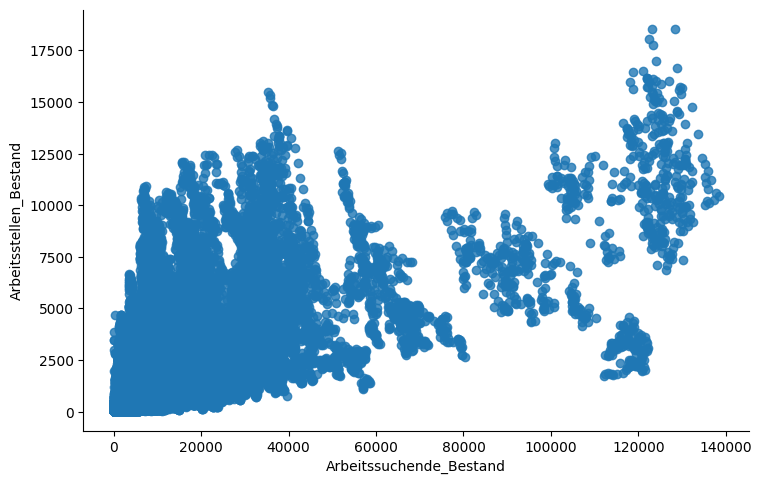

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic scatterplot with regression line
sns.lmplot(
    x='Arbeitssuchende_Bestand', 
    y='Arbeitsstellen_Bestand', 
    data=combined_excel_df, 
    aspect=1.5, 
    line_kws={'color': 'red'}
)

plt.title('Effect of Arbeitssuchende_Bestand on Arbeitsstellen_Bestand')
plt.xlabel('Arbeitssuchende_Bestand')
plt.ylabel('Arbeitsstellen_Bestand')
plt.show()

Plot the beveridge curve by Berufsgruppe:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Faceted scatterplot with regression line per Berufsgruppe
sns.lmplot(
    x='Arbeitssuchende_Bestand', 
    y='Arbeitsstellen_Bestand',  
    hue='Beruf',  # Optional: if you want color by group
    col='Beruf',  # Facet by each Berufsgruppe 
    data=combined_excel_df, 
    col_wrap=4,          # Adjust for layout (e.g., 4 plots per row)
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    sharex=False,        # Optional: don't force same x-axis scale
    sharey=False         # Optional: don't force same y-axis scale
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Arbeitsstellen vs. Arbeitslose by Berufsgruppe')
plt.show()


Plot the beveridge for each Berufsgruppe and each Bundesland

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine Berufsgruppe and Bundesland into a new faceting column
combined_excel_df['facet_group'] = (
    combined_excel_df['Beruf'].astype(str) + 
    ' | BL: ' + 
    combined_excel_df['Bundesland'].astype(str)
)

# Plot: One scatterplot per (Berufsgruppe, Bundesland)
sns.lmplot(
    x='Arbeitssuchende_Bestand', 
    y='Arbeitsstellen_Bestand', 
    col='facet_group',
    data=combined_excel_df,
    col_wrap=4,         # 4 plots per row
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    scatter_kws={'s': 15, 'alpha': 0.6},  # Optional: smaller, transparent points
    sharex=False,
    sharey=False
)

plt.subplots_adjust(top=0.92)
plt.suptitle('Effect of Bewerber on Vakanzzeit by Berufsgruppe and Bundesland', fontsize=16)
plt.show()


Next, I compare the data on Arbeitsstellen extracted in this jupyter file to the other data on Arbeitstellen from the BA. One crucial difference is that the data without Arbeitssuchenden is a floating yearly average, while the data with Arbeitssuchende is in absolute numbers. 

In [ ]:
# Import Data from BA and Rente
import pandas as pd

pd.set_option('display.max.rows', None)
pd.set_option('display.max.columns', None)

BA = pd.read_csv(r"C:\\Users\\jhummels\\OneDrive - DIW Berlin\\Gehlen, Annica's files - retirement-labor-shortages\\Data\\complete_df_BA.csv")
Labor_Market_Tightness = pd.read_csv("labor_market_tightness_cleaned.csv")

In [ ]:
BA.rename(columns={"Bundesland": "bland", "BKZ": "kldb2010_3_akvs", "Year": "year"}, inplace=True)
Labor_Market_Tightness.rename(columns={"Bundesland": "bland", "BKZ": "kldb2010_3_akvs", "Year": "year"}, inplace=True)

In [ ]:
# Fix bland names
ordered_labels = [ '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '1.1', '1.11', '1.12', '1.13', '1.14', '1.15', '1.16', 
                  '1.17', '1.18', '1.19']
rename_map = {label: idx + 1 for idx, label in enumerate(ordered_labels)}
Labor_Market_Tightness.loc[:, 'bland'] = (
    Labor_Market_Tightness['bland'].astype(str).str.strip().map(rename_map)
)
Labor_Market_Tightness['bland'] = Labor_Market_Tightness['bland'].astype('Int64')

In [ ]:
print(BA.shape)
print(Labor_Market_Tightness.shape)
print(BA.isnull().sum())
print(Labor_Market_Tightness.isnull().sum()) 

In [ ]:
BA["bland"].unique()   

Merging the two BA data frames together: 

In [ ]:


merged = Labor_Market_Tightness.merge(BA, on=['kldb2010_3_akvs', 'bland', 'year', 'Month'], how='left')
print(merged.shape) 
print(merged.isnull().sum())



Here, I look at the correlation between the two data frames that measure similar variables. The variables show relatively high correlations. The number of unemployed in both data sets (Arbeitslose and Arbeitslose_Bestand) has a correlation of 0.74 for example. And the number of vacancies (Bestand and Arbeitsstellen_Bestand) has a correlation of 0.83. 

In [ ]:
# Output the correlation matrix as a heatmap
####################################################################################

import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = merged.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

# Add titles and labels
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot